## Build test data

We'll use a star with a clear sinusoidal signal and multiple sectors for complete coverage on the different data types for targets that require TPF content.

We'll also generate a clear and a failure mode synthetic light curve for testing the detection methods.

We'll choose a single-sector star for download testing.

In [1]:
from fleck import generate_spots, Star
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(802)
N = 2
spot_contrast = np.random.uniform(0.5, 1., size=N)
rotation_period = np.random.uniform(1.5, 27., size=N)/5
u_ld = [0.5, 0.2]

spot_radius = np.random.uniform(0.05, 0.15, size=N)
min_latitude = np.random.uniform(30, 60, size=N)
max_latitude = np.random.uniform(61, 85, size=N)

t = np.arange(0, 27., 0.02)
yerr = 1e-6*np.array([500, 100])

n_phases = len(t)
n_inclinations = 1
n_spots = np.random.uniform(10, 30, size=N).astype(int)

In [3]:
np.random.seed(802)

sim = np.zeros((N, len(t)))
obs = np.zeros((N, len(t)))

for idx in range(N):
    lons, lats, radii, inc_stellar = generate_spots(min_latitude[idx], max_latitude[idx],
                                                   spot_radius[idx], n_spots[idx],
                                                   n_inclinations=n_inclinations)
    star = Star(spot_contrast = spot_contrast[idx], n_phases=n_phases, 
                u_ld = u_ld, rotation_period = rotation_period[idx])
    lc = star.light_curve(lons, lats, radii, inc_stellar, times=t)
    
    lc -= np.mean(lc)
    lc += 1.
    
    sim[idx, :] = lc.flatten()
    obs[idx, :] = lc.flatten() + yerr[idx] * np.random.randn(len(t))


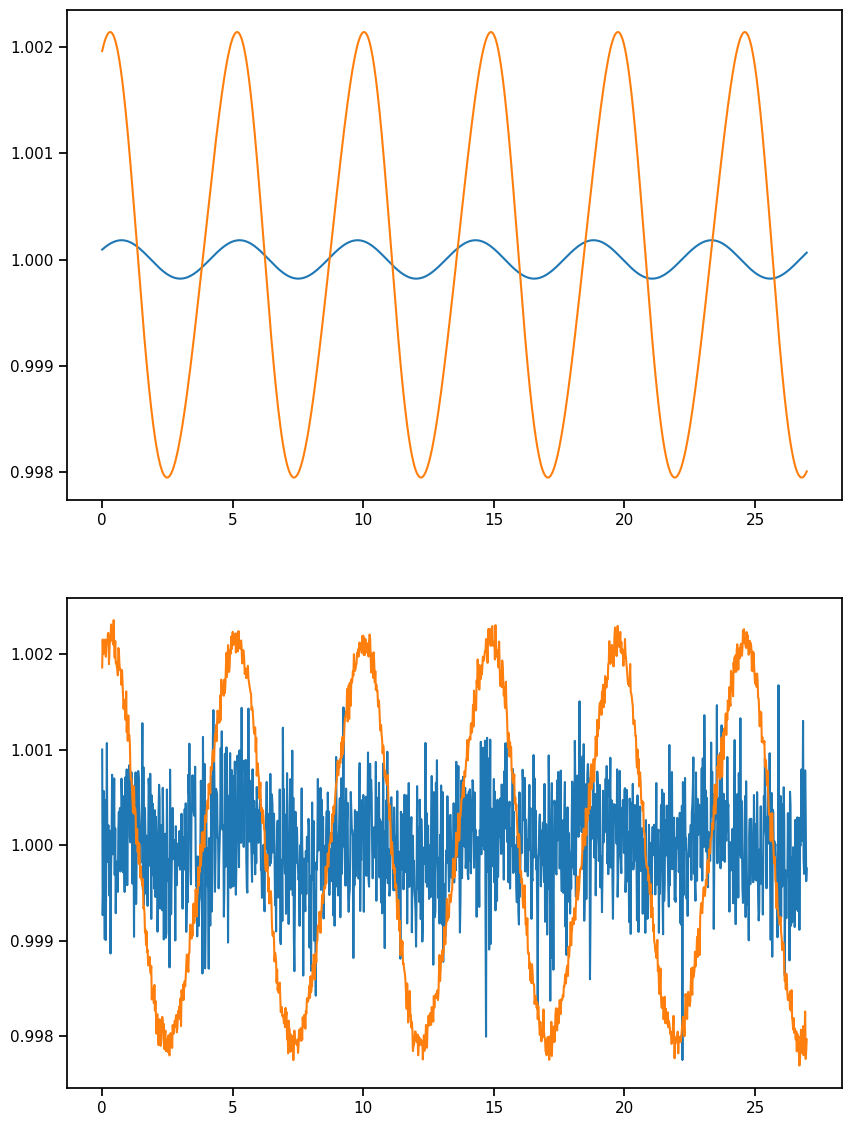

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10, 14))
ax[0].plot(t, sim.T)
ax[1].plot(t, obs.T)
plt.show()

### Test methods

In [5]:
from michael import janet
import glob
import lightkurve
import numpy as np
gj = janet('synthetic', 0., 0., output_path = 'tests/data')
gj.sectors = ['0']
gj.sectorlist = ['0']
gsfile = glob.glob('tests/data/synthetic*pass*')[0]
gprot = float(gsfile.split('_')[-2])
gsyn = np.genfromtxt(gsfile)
gj.void['clc_0']  = lightkurve.LightCurve(time = np.arange(0, 27., 0.02),
                                            flux = gsyn)
gj.get_rotation(period_range = (3, 6))

2022-10-21 11:03:48.625382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Running Simple Astropy Lomb-Scargle on Sector 0 on star synthetic ###
### Completed Simple Astropy Lomb-Scargle for Sector 0 on star synthetic ###
### Running Wavelet Estimation for Sector 0 on star synthetic ###


100%|██████████████████████████████████████████| 27/27 [00:00<00:00, 176.47it/s]

### Completed Wavelet Estimation for Sector 0 on star synthetic ###
### Running Composite ACF estimation for Sector 0 on star synthetic ###
### Completed Composite ACF estimation for Sector 0 on star synthetic ###
### Running ACF Estimation on star synthetic ###
### Completed ACF Estimation for Sector 0 on star synthetic ###


In [8]:
gj.results

,SLS,e_SLS,h_SLS,f_SLS,SW,e_SW,h_SW,CACF,e_CACF,h_CACF,ACF,e_ACF
0,4.882286,0.319844,0.000058,0.0,4.859937,0.12871,1.004542,4.85299,0.146332,0.719849,4.82,NaN


In [9]:
gj.validate_rotation()

In [10]:
gj.results

,SLS,e_SLS,h_SLS,f_SLS,SW,e_SW,h_SW,CACF,e_CACF,h_CACF,...,f_p2p_ACF,s_SLS,s_SW,s_CACF,s_ACF,f_overall,overall,e_overall,method_overall,p2p_overall
0,4.882286,0.319844,0.000058,0.0,4.859937,0.12871,1.004542,4.85299,0.146332,0.719849,...,1.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
best,4.882286,0.319844,0.000058,0.0,4.859937,0.12871,1.004542,4.85299,0.146332,0.719849,...,NaN,0,0,0,0,0,4.859937,0.12871,SW,0.004177


In [16]:
from numpy.testing import assert_almost_equal, assert_array_equal

assert_almost_equal(gj.results.loc['best','overall'], gprot, decimal=5)


AssertionError: 
Arrays are not almost equal to 5 decimals
 ACTUAL: 4.859937074459677
 DESIRED: 4.86

In [20]:
for pre in ['', 'e_','snr_','p2p_']:
    print(gj.results.loc['best',[f'{pre}SLS',f'{pre}SW',f'{pre}CACF', f'{pre}ACF']])

SLS     4.882286
SW      4.859937
CACF     4.85299
ACF         4.82
Name: best, dtype: object
e_SLS     0.319844
e_SW       0.12871
e_CACF    0.146332
e_ACF          NaN
Name: best, dtype: object
snr_SLS     26.488717
snr_SW      31.387566
snr_CACF    30.117689
snr_ACF     19.429685
Name: best, dtype: object
p2p_SLS      0.00416
p2p_SW      0.004177
p2p_CACF    0.004182
p2p_ACF     0.004143
Name: best, dtype: object


In [22]:
    gj.results.loc['best', ['SLS','SW','CACF', 'ACF']] = \
                [5., 10., 10., 5.]
    gj.results.loc['best', ['e_SLS','e_SW','e_CACF', 'e_ACF']] = \
                [1., 1., 1., 1.]
    gj.results.loc['best', ['snr_SLS','snr_SW','snr_CACF', 'snr_ACF']] = \
                [50., 10., 20., 50.]

In [23]:
j = gj

In [24]:
    # Check to see if they agree closely with one another
    methods = ['SLS', 'SW', 'CACF', 'ACF']
    best = j.results.loc['best', ['SLS','SW','CACF', 'ACF']]#.dropna()
    ebest = j.results.loc['best', ['e_SLS','e_SW','e_CACF', 'e_ACF']]#.dropna()
    snrs = j.results.loc['best', ['snr_SLS','snr_SW','snr_CACF', 'snr_ACF']]#.dropna()']
    p2ps = j.results.loc['best', ['p2p_SLS','p2p_SW','p2p_CACF', 'p2p_ACF']]#.dropna()']

    j.results['f_overall'] = np.zeros(len(j.results)).astype(int)

    # If they agree, then pick the one with the highest snr value
    if np.abs(np.diff(best.dropna(), len(best.dropna())-1)) < np.sqrt(np.nansum(ebest**2)):
        s = np.argmax(snrs)
        j.results.loc['best', 'overall'] = best[s]
        j.results.loc['best', 'e_overall'] = ebest[s]
        j.results.loc['best', 'method_overall'] = methods[s]
        j.results.loc['best', 'p2p_overall'] = p2ps[s]

    # If they disagree, see if two of them are in agreement
    else:
        # We check in this order, as the priority is CACF -> SW -> SLS -> ACF
        d = np.abs(np.diff(best[['SLS','SW']])) < np.sqrt(np.sum(ebest[['e_SLS', 'e_SW']]**2))
        c = np.abs(np.diff(best[['ACF', 'CACF']])) < ebest[['e_CACF']].values
        b = np.abs(np.diff(best[['SLS','CACF']])) < np.sqrt(np.sum(ebest[['e_SLS', 'e_CACF']]**2))
        a = np.abs(np.diff(best[['SW','CACF']])) < np.sqrt(np.sum(ebest[['e_SW', 'e_CACF']]**2))


In [29]:
np.abs(np.diff(best.dropna(), len(best.dropna())-1))

array([0.0], dtype=object)

In [33]:
np.sum(np.abs(np.diff(best)))

10.0

In [34]:
tw

2.0

In [35]:
from michael.validate import validator, longest_sectors


In [36]:
        longest = longest_sectors(gj)


In [37]:
longest

'0'

In [38]:
gj.sectors = ['0', '43-44','55-56']

In [39]:
longest = longest_sectors(gj)
longest

['43-44', '55-56']

In [40]:
len(longest) > 1

True

In [41]:
longest = longest[0]

In [42]:
longest

'43-44'

In [45]:
len('0'.split('-'))

1

In [50]:

import numpy as np
from numpy.testing import assert_almost_equal, assert_array_equal
from michael import janet
from michael.data import data_class
import astropy.units as u

# Using a known rotator from the Gaia catalogue
gaiaid = 38329666836450304
ra = 59.560442
dec = 12.627969

j = janet(gaiaid, ra, dec, pipeline = 'tess-sip', output_path = 'tests/data')
data = data_class(j)
data.check_eleanor_setup()
data.build_tess_sip_lc()
j.get_rotation(period_range = (2, 8))

Already have data downloaded for Gaia ID 38329666836450304.


Running pixels in aperture: 100%|████████████| 300/300 [00:02<00:00, 132.21it/s]


AttributeError: 'list' object has no attribute 'split'

In [55]:
longest = longest_sectors(j)

In [54]:
j.sectors = ['0']

In [56]:
longest

'0'

In [57]:
j.sectors[0]

'0'